In [1]:
# imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from neurodiffeq import diff
from neurodiffeq.ode import solve 
from neurodiffeq.solvers import Solver1D
from neurodiffeq.conditions import IVP
from neurodiffeq.networks import FCNN 
from neurodiffeq.monitors import Monitor1D
# %matplotlib notebook

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Using (Deprecated) Solve:

In [2]:
# function: du/dt = -lambda * u, initial condition: u(0) = 1
A, lambda_val = 1, 1

# specify the ODE and initial condition
exponential = lambda u, t: diff(u, t) + lambda_val * u 
init_val_ex = IVP(t_0=0.0, u_0=1.0)

# solve the ODE
solution_ex, loss_ex = solve(ode=exponential, condition=init_val_ex, t_min=0.0, t_max=2.0)

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/neurodiffeq/ode.py:262: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  FutureWarning,
Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 296.52it/s]


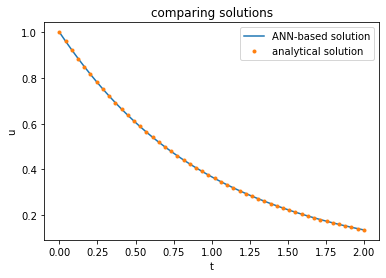

In [3]:
# plot the analytical and network solutions
ts = np.linspace(0, 2.0, 50)
u_network = solution_ex(ts, to_numpy=True)
u_analytical = A * np.exp(-lambda_val * ts)

plt.figure()
plt.plot(ts, u_network, label='ANN-based solution')
plt.plot(ts, u_analytical, '.', label='analytical solution')
plt.ylabel('u')
plt.xlabel('t')
plt.title('comparing solutions')
plt.legend()
plt.show()

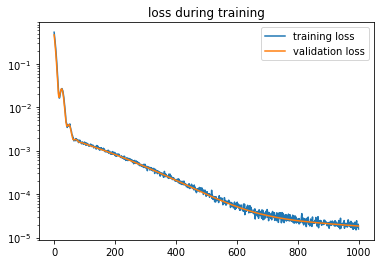

In [4]:
# plot the training and validation losses
plt.figure()
plt.plot(loss_ex['train_loss'], label='training loss')
plt.plot(loss_ex['valid_loss'], label='validation loss')
plt.yscale('log')
plt.title('loss during training')
plt.legend()
plt.show()

# Using Solver:

/Users/HariRaval/miniconda3/envs/thesis/lib/python3.7/site-packages/neurodiffeq/monitors.py:48: UserWarning: You seem to be using jupyter notebook with '%matplotlib inline' which can lead to monitor plots not updating. Consider using '%matplotlib notebook' or '%matplotlib widget' instead.
  UserWarning)
Training Progress:  98%|█████████▊| 982/1000 [00:02<00:00, 339.58it/s]

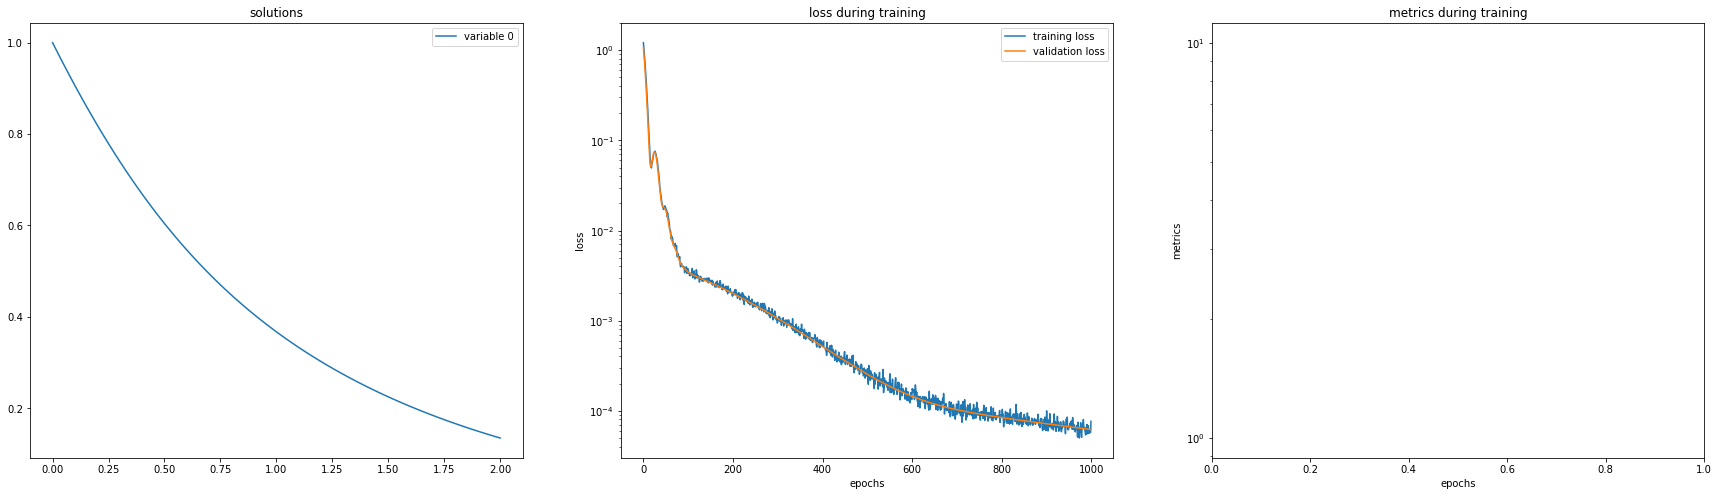

Training Progress: 100%|██████████| 1000/1000 [00:03<00:00, 265.67it/s]


In [5]:
# create a monitor and turn it into a callback instance
monitor = Monitor1D(t_min=0.0, t_max=2.0, check_every=1000)
monitor_callback = monitor.to_callback()
lambda_val = 1
exponential = lambda u, t: [diff(u, t) + lambda_val * u] # NOTE: required brackets here for some reason
init_vals = [IVP(t_0=0.0, u_0=1.0)]

# create the network
nets_lv = [FCNN(n_input_units=1, n_output_units=1, hidden_units=(32, 32), actv=torch.nn.Tanh)]

# instantiate a solver instance
solver = Solver1D(
    ode_system=exponential,
    conditions=init_vals,
    t_min=0.0,
    t_max=2.0,
    nets=nets_lv
)

# fit the solver (i.e. train the neural networks)
solver.fit(max_epochs=1000, callbacks=[monitor_callback])
# solver.fit(max_epochs=1000)

# get the solution
solution_lv = solver.get_solution()